<a href="https://colab.research.google.com/github/alejomd17/Econometria-Espacial-Indicadores-de-Asociacion-Espacial/blob/main/LISA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AEDE: Índice de Moran e Indicadores Locales de Asociaión Espacial

En este notebook se muestra cómo implementar en Python el Índice Global de Moran y los Indicadores Locales de Asociación Espacial (LISA pos sus siglas en Inglés). Ambas son medidas que caracterizan la distribución espacial de una variable. Sin embargo, el índice de Moran mide el grado dependencia o autocorrelación espacial **promedio**, es decir, responde a la pregunta ¿en general las unidades espaciales vecinas están relacionadas entre sí, o son independientes las unas de las otras, con respecto a la variable analizada? Si las unidades espaciales están relacionadas entre sí, el índice de Moran permite discernir si está asociación es positiva o negativa: ¿En promedio, son las unidades espaciales vecinas similares entre sí (dependencia positiva), son opuestas (depedencia negativa), o no hay relación (distribución aleatoria)?

Los Indicadores Locales de Asociación Espacial, comúnmente llamados (LISA - *Local Indicators of Spatial Association*) no preguntan acerca del patrón general o promedio que prevalece en la muestra, si no que preguntan por el tipo de patrón que se presenta alredador del vecindario de *cada* unidad espacial. Por ejemplo, es posible que aunque a nivel global, el índice de Moran sugiera que existe dependencia espacial positiva, a nivel local pueden exisitir algunos vecindarios de unidades espaciales que escapen a la tendencia, y por tanto exhibir correlación negativa o no exhibir ningún tipo de correlación, o viceversa. 

La implementación de estas medidas de autocorrelación espacial se aplicará a datos referentes al índice de necesadades básicas insatifechas (INBI) de los municipios Colombianos calculado por el DANE según el Censo de Población de 2005.

# Preparación



## Instalar y cargar paquetes de Python
Instale los paquetes requeridos para procesar y graficar información espacial. En este notebook en particular, adicional al paquete *geopandas* y sus dependencias para procesar datos geográficas, se instalael paquete *pysal* que contiene un abanico de funciones para hacer AEDE y en particular, contienen funciones para calcular el índice global de Moran y los LISA.

In [ ]:
# Bibliotequa GDAL (Geospatial Data Abstraction Library)
!apt install gdal-bin python-gdal python3-gdal --quiet
# Instalar rtree - Requerido por Geopandas
!apt install python3-rtree --quiet
# Instalar descartes - Requerido por Geopandas
!pip install descartes --quiet
# Instalar Geopandas
!pip install git+git://github.com/geopandas/geopandas.git --quiet

# Install geovisualization libraries
!pip install folium  --quiet
!pip install plotly_express  --quiet
!pip install mapclassify --quiet


# Install Pysal - Spatial Statistics
!pip install pysal --quiet
!pip install splot --quiet

!pip install pytest --quiet
!pip install pytest-cov --quiet


Reading package lists...
Building dependency tree...
Reading state information...
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 up

In [ ]:
# Procesamiento de datos espaciales
import pandas as pd 
import geopandas as gpd
import fiona
from shapely.geometry import Point

# Funciones matemàticas
import numpy as np

# Producciòn de gràficos y mapas
import matplotlib.pyplot as plt 
%matplotlib inline
import folium
import plotly
import plotly_express as px
import seaborn as sns

# AEDE
from libpysal.weights import Queen, attach_islands, KNN
from esda.moran import Moran
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from pysal.explore import esda
from pysal.lib import weights
import pysal as ps

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## Gestión de datos

Aquí se monta el Drive para acceder a los datos. Si prefiere esta alternativa para acceder a los datos no olvide acceder al Classroom y añadir los archivos su Drive personal. Sin embargo, recuerde que hay otras maneras de acceder a los datos desde un notebook de Python.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wGG8bxC0o2iDVaYxE8lbCYuiBa4FEax-7vdhywFHrx6JWBz01kKEQw
Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/Classroom/Datos Geográficos/Shp Col Mun"

colMun.dbf  colMun.prj	colMun.shp  colMun.shx	colMun.zip


### Cargar datos
Lea archivo shape de la división municipal de Colombia.

In [ ]:
shp = gpd.read_file("/content/drive/My Drive/Classroom/Datos Geográficos/Shp Col Mun/colMun.shp")
shp.sample(3)

,OBJECTID,codigo,AREA_OFICI,ENTIDAD_TE,NOM_DEPART,NOM_MUNICI,COD_DEPTO,SHAPE_area,SHAPE_len,DIVIPOLA,geometry
897,900,20517,521.0,Cabecera Municipal,CESAR,PAILITAS,20,5.520275e+08,115694.125941,20517,"POLYGON ((1044311.696 1469429.544, 1044305.808..."
25,26,8372,176.0,Cabecera Municipal,ATLANTICO,JUAN DE ACOSTA,08,1.689976e+08,75387.247164,08372,"POLYGON ((875406.626 1687067.171, 875406.625 1..."
510,511,73275,100.0,Cabecera Municipal,TOLIMA,FLANDES,73,9.822611e+07,54594.400236,73275,"POLYGON ((921779.809 963358.486, 921757.487 96..."


Lea archivo de datos *CSV* con INBI municipal de 2005.

In [ ]:
nbi = pd.read_csv('/content/drive/My Drive/Classroom/Datos/nbi.csv', sep=',', encoding='latin-1')
nbi.sample(5)

,nom_depto,depto,mun,nom_mun,nbicab,nbires,nbi2005,codigo
9,ANTIOQUIA,5,40,ANORI,41.610360,56.238361,48.140066,5040
268,BOYACA,15,572,PUERTO BOYACA,29.975848,58.472443,39.310810,15572
817,QUINDIO,63,1,ARMENIA,13.037766,19.463837,13.212727,63001
1041,VALLE DEL CAUCA,76,869,VIJES,14.740484,30.872307,21.145420,76869
390,CAUCA,19,622,ROSAS,26.546213,71.623794,65.929242,19622


### Cruce de datos
Chequee los tipos de variables o columnas que contienen tanto el objeto `shp` como el objeto `nbi`. En particular, inspeccione la variable `código`, la cual contiene los códigos *Divipola* del DANE, que sirven como la llave para cruzar ambas fuentes de información. Esta variable debe aparecer como del mismo tipo en ambos conjuntos de datos para poder cruzarlos sin contratiempo; sin embargo, note que ese no es el caso.

In [ ]:
# Cheque tipos de las columnas
print('\n',shp.dtypes)
print('\n',nbi.dtypes)
print('\n',shp.codigo.dtypes)
print('\n',nbi.codigo.dtypes)


 OBJECTID        object
codigo          object
AREA_OFICI     float64
ENTIDAD_TE      object
NOM_DEPART      object
NOM_MUNICI      object
COD_DEPTO       object
SHAPE_area     float64
SHAPE_len      float64
DIVIPOLA        object
geometry      geometry
dtype: object

 nom_depto     object
depto          int64
mun            int64
nom_mun       object
nbicab       float64
nbires       float64
nbi2005      float64
codigo         int64
dtype: object

 object

 int64


En consecuencia, a continuación convertimos la variable `codigo` a una variable de tipo `int` o *integer* (columna de valores numéricos enteros) en ambos conjuntos de datos. Así prevenimos contratiempos al cruzar los datos.

In [ ]:
# Convertir variables de enlace a un tipo comùn
shp.codigo = shp.codigo.astype('int')
nbi.codigo = nbi.codigo.astype('int')

print('\n',shp.codigo.dtypes)
print('\n',nbi.codigo.dtypes)


 int64

 int64


Ahora, proceda a cruzar ambas fuentes de información.

In [ ]:
# Cruzar datos
shp = shp.merge(nbi,on='codigo',how='inner') # 'outer'
shp.shape

(1120, 18)

# Pesos espaciales

Para calcular el índice global de Moran y los LISA, es menester calcular el rezago espacial de la variable de interés. EL rezago espacial da cuenta del comportamiento de la variable de interés en las unidades vecinas a la unidad espacial de referencia. Para calcular el rezago espacial se hace uso de la llamada matriz de pesos espaciales, denotada comúnmente como la matriz **W**. 

Cuando la matriz **W** es estandarizada por filas (la suma de las filas es igual a 1), el rezago espacial puede interpretarse como el valor promedio que toma una variable en las unidades vecinas de la unidad espacial de referencia.

Con datos de tipo polígono, es práctica común computar la matriz de pesos espaciales según un criterio de vecindad o contigüidad geográfica. En este caso, se consideran como vecinas aquellas unidades espaciales que comparten frontera. Comúnmente se consideran dos tipos de vecindad: tipo **Torre** (*Rook*) y tipo **Reina** (*Queen*). En el criterio tipo **Torrre** dos unidades espaciales son consideradas como vecinas si comparten al menos un vértice o punto de sus fronteras. En el criterio tipo **Reina** deben compartir al menos dos vértices o puntos.

Sin embargo, conviene recoradar que existen otros tipos de métodos para definir la matriz de pesos espaciales, como criterios de vecindad por distancia. Al respecto ver la ayuda de [libpysal](https://pysal.org/libpysal/api.html). 

En el ejemplo que se desarrollará a continuación se utilizará una matriz de vecindades tipo **Reina**. Sin embargo, dado que Colombia posee algunos territorios insulares, correspondientes a los municipios del *Archipièlago de San Andŕes y Providencia*, al generar las vecindades tipo **Reina** estos municipios quedarán sin vecinos. Lo anterior puede producir incovenientes a la hora de calcular el rezago espacial y, por tanto, a la hora de calcular los LISA. Ahora bien, este inconveniente puede ser       solucionado asignando como vecino de las islas el territorio más cercano, usando la funciòn `libpysal.weights.attach_islands()`

Para identificar los municipios del Archipiélago se usa una expresión regular aplicada a la columna `NOM_DEPART`.

In [ ]:
# Identificar municipios Archipìélago de San Andrès
print(shp.NOM_DEPART.str.contains('ARCHI').value_counts(), '\n')
shp[shp.NOM_DEPART.str.contains('ARCHI')]

False    1118
True        2
Name: NOM_DEPART, dtype: int64 



,OBJECTID,codigo,AREA_OFICI,ENTIDAD_TE,NOM_DEPART,NOM_MUNICI,COD_DEPTO,SHAPE_area,SHAPE_len,DIVIPOLA,geometry,nom_depto,depto,mun,nom_mun,nbicab,nbires,nbi2005
964,970,88001,24.0,CAP. DEPTO,"ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y SANT...",SAN ANDRÉS,88,2.729878e+07,39675.971744,88001,"POLYGON ((168751.271 1893590.814, 168742.382 1...",SAN ANDRES,88,1,SAN ANDRES,52.045874,15.019908,42.452795
965,971,88564,20.0,Cabecera Municipal,"ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y SANT...",PROVIDENCIA Y SANTA CATALINA (Santa Isabel),88,2.110905e+07,25990.737032,88564,"POLYGON ((206830.751 1982567.115, 206830.746 1...",SAN ANDRES,88,564,PROVIDENCIA,23.000708,17.263231,19.699381


Si quiséramos eliminar estos municipios para que las vecindades tipo **Reina** no queden con islas podríamos usar la siguiente instrucción para filtrar los datos:
```
# Descarte municipios del Archipièlago
shpf = shp[shp.NOM_DEPART.str.contains('ARCHI')!=True]
shpf.shape
```
Sin embargo, este no es el proceder adoptado aquí.

Al cargar un *GeoDataFrame*, geopandas asigna automáticamente un identificador o `índice` numérico para cada observación o fila en la base de datos. 

Al crear los pesos espaciales, automáticamente se asigna este *índice* como el identificador de sus elementos. Ahora bien, dado que como variable identificadora de cada observación estamos utilizando la variable `codigo`, que contiene el código *Divipola* de los municipios colombianos, conviene que el identificador subyacente de fila sea este.

Por lo anteiror, se ordena la base de datos según la variable `código` y se establece esta como el *índice* de los datos.

In [ ]:
shp.index # Inspeccione el índice o identificador interno de fila

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119],
           dtype='int64', length=1120)

In [ ]:
shp.sort_values('codigo',ascending=True,inplace=True) # Ordene de manera ascendente
shp.set_index('codigo',drop=False,inplace=True) # Establezca una variable de 
              # de los datos como el índice, pero consérvela como una columna.
shp.index # Inspeccione el índice

Int64Index([ 5001,  5002,  5004,  5021,  5030,  5031,  5034,  5036,  5038,
             5040,
            ...
            97001, 97161, 97511, 97666, 97777, 97889, 99001, 99524, 99624,
            99773],
           dtype='int64', name='codigo', length=1120)

Es importante resaltar que la matriz de pesos espaciales no es representada como tal, sino como un **diccionario**, por razones de eficiencia. El número de entradas o elementos del **diccionario** corresponde al número de unidades espaciales que contiene el *GeoDataFrame*. Cada elemento está conformado por dos vectores: uno que contiene los identificadores (índices de fila) de las observaciones vecinas a cada unidad espacial, y otro que contiene los pesos o ponderaciones asignadas a cada observación vecina.

A continuación, en primer lugar creamos una lista de vecindades tipo **Reina** con la función `Queen.from_dataframe()`. Este listado de vecindades es transformado de tal forma que sea equivalente a una matriz de pesos espaciales estandarizada por filas, con la función `.transform`.

In [ ]:
# Get Weights (Queen)
wq = Queen.from_dataframe(shp,idVariable='codigo') # Genere vecindades tipo Reina
wq.transform = 'r' # Genere pesos espaciales estandarizados por fila
print('Matriz W',wq)
print('\nproporción enlaces no nulos', "%.3f"%wq.pct_nonzero,'\n')


('WARNING: ', 88001, ' is an island (no neighbors)')
('WARNING: ', 88564, ' is an island (no neighbors)')
Matriz W <libpysal.weights.contiguity.Queen object at 0x7ff03b3d05f8>

proporción enlaces no nulos 0.519 



/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:172: UserWarning:

The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 88001, 88564.



## Operaciones sobre los pesos espaciales

En las siguientes líneas se ilustra la manera en la cual se puede explorar los pesos espaciales, y algunas operaciones que se pueden aplicar a los mismos. 



In [ ]:
# Inspeccione los pesos de Medellín (divipola==5001)
wq[5001]

{5036: 0.08333333333333333,
 5088: 0.08333333333333333,
 5212: 0.08333333333333333,
 5240: 0.08333333333333333,
 5266: 0.08333333333333333,
 5318: 0.08333333333333333,
 5347: 0.08333333333333333,
 5360: 0.08333333333333333,
 5380: 0.08333333333333333,
 5607: 0.08333333333333333,
 5615: 0.08333333333333333,
 5656: 0.08333333333333333}

In [ ]:
# Funciones o métodos aplicables a objeto de pesos espaciales
dir(wq)

['_W__get_id_order',
 '_W__neighbors_0',
 '_W__set_id_order',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_sparse',
 '_cache',
 '_cardinalities',
 '_component_labels',
 '_histogram',
 '_id2i',
 '_id_order',
 '_id_order_set',
 '_islands',
 '_max_neighbors',
 '_min_neighbors',
 '_n',
 '_n_components',
 '_pct_nonzero',
 '_reset',
 '_sparse',
 '_transform',
 'asymmetries',
 'asymmetry',
 'cardinalities',
 'component_labels',
 'diagW2',
 'diagWtW',
 'diagWtW_WW',
 'from_WSP',
 'from_adjlist',
 'from_dataframe',
 'from_file',
 'from_iterable',
 'from_networkx',
 'from_shapefile',
 'full',
 'get_transform',
 'histogram',
 'id2i',
 'id_o

Genere un histograma de los pesos

In [ ]:
wq.histogram

[(0, 2),
 (1, 4),
 (2, 20),
 (3, 57),
 (4, 194),
 (5, 255),
 (6, 234),
 (7, 169),
 (8, 92),
 (9, 49),
 (10, 20),
 (11, 17),
 (12, 3),
 (13, 2),
 (14, 0),
 (15, 0),
 (16, 1),
 (17, 0),
 (18, 0),
 (19, 1)]

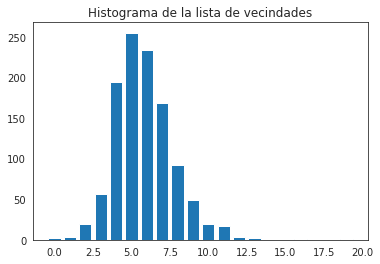

In [ ]:
with sns.axes_style('white'):
 hist = np.array(wq.histogram,ndmin=2)
 plt.bar(hist[:,0],hist[:,1])
 plt.title('Histograma de la lista de vecindades')

### Añadir islas a las vecindades por contigüidad
A continuación, conectamos las islas a su vecino más cercano según un criterio de distancia a vuelo de **pájaro**

In [ ]:
w_knn1 = KNN.from_dataframe(shp,k=1) # K vecindades más cercanas a vuelo de pájaro
wqs = attach_islands(wq,w_knn1) # Añada las islas a las vecindades tipo reina 

/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:172: UserWarning:

The weights matrix is not fully connected: 
 There are 280 disconnected components.

/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:172: UserWarning:

The weights matrix is not fully connected: 
 There are 2 disconnected components.



In [ ]:
# Note que ahora no hay islas:
wqs.islands

[]

In [ ]:
# Inspeccione el vecino asignado a una de las islas:
wqs[88001]

{88564: 1.0}

Ahora, represente las vecindades o conexiones entre unidades espaciales.

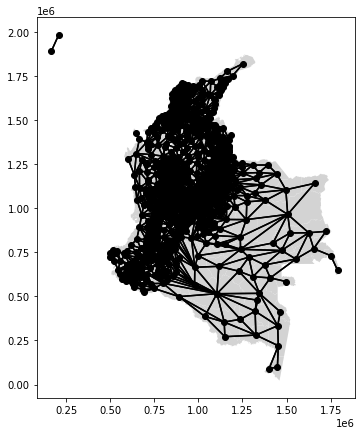

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
shp.plot(color='lightgrey', ax=ax)
wqs.plot(shp, ax=ax) # color='firebrickred', node_kws=dict(marker='*', color='k'), indexed_on='codigo'
plt.show()

# AEDE

Utilizando la matriz de pesos espaciales creada, a continuación se analiza el índice de necesidades básicas insatisfechas (NBI), el cual reporta el porcentaje o proporción de población pobre en cada municipio en 2005.

Primeramente, se genera un mapa coropleto para ilustrar la distribución espacial de la variable.

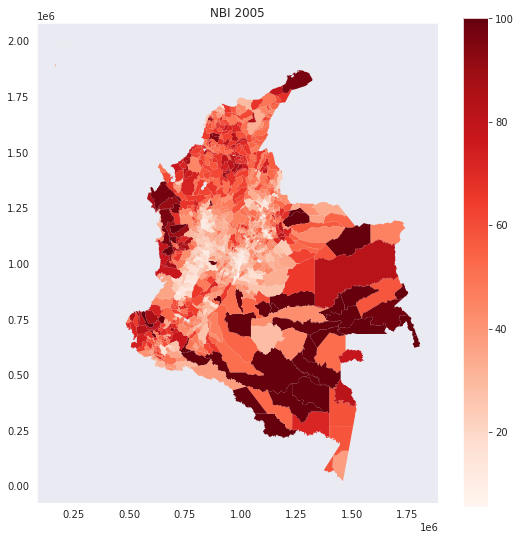

In [ ]:
with sns.axes_style('dark'):
 shp.plot(column='nbi2005',cmap='Reds',
          legend=True, edgecolor='None',figsize=(9,9))
 plt.title('NBI 2005')

## Rezago espacial

El rezago espacial captura el comportamiento de la variable de interés en las observaciones vecinas. Cuando la matriz de pesos espaciales está estandarizada por filas, el rezago espacial se puede interpretar como el valor promedio que toma la variable para los vecinos.


In [ ]:
# Sptial lag
# shp['nbicab_lag'] = weights.lag_spatial(wqs, shp['nbicab'])
# shp['nbires_lag'] = weights.lag_spatial(wqs, shp['nbires'])
shp['nbi2005_lag'] = weights.lag_spatial(wqs, shp['nbi2005'])

El diagrama de dispersión de Moran permite ilustrar la relación de las unidades espaciales con respecto a sus vecinos.

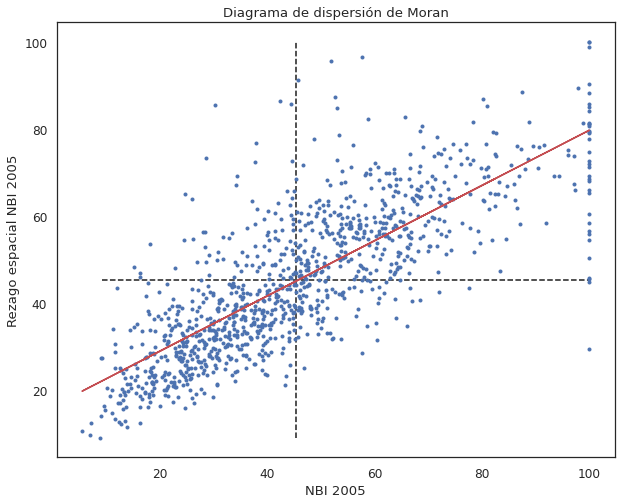

In [ ]:
sns.set(style='white', palette="deep", font_scale=1.1, rc={"figure.figsize": [7, 7]})

b, a = np.polyfit(shp.nbi2005, shp.nbi2005_lag, 1)

plt.plot(shp['nbi2005'],shp['nbi2005_lag'],'.')

# dashed vert at mean of the price
plt.vlines(shp.nbi2005.mean(), 
           shp.nbi2005_lag.min(), shp.nbi2005_lag.max(),
           linestyle='--')
# dashed horizontal at mean of lagged price
plt.hlines(shp.nbi2005.mean(), 
           shp.nbi2005_lag.min(), shp.nbi2005_lag.max(), 
           linestyle='--')

# red line of best fit using global I as slope
plt.plot(shp.nbi2005, a + b*shp.nbi2005, 'r')
plt.title('Diagrama de dispersión de Moran: ' + str(b.round(3)) )
plt.ylabel('Rezago espacial NBI 2005')
plt.xlabel('NBI 2005')
plt.show()

## Índice Global de Moran

El índice global de Moran es una medida de la dirección e intensidad de la dependencia espacial. 

In [ ]:
# Índice de Moran
mi = Moran(shp.nbicab.fillna(100),wqs, permutations=10000)
print('NBI Cabecera - Ìndice de Moran :',round(mi.I, 3), '\n p-valor: ',round(mi.p_sim,5))


NBI Cabecera - Ìndice de Moran : 0.634 
 p-valor:  0.0001


Dado que la distribución del estadístico de Moran no es simétrica, en consecuencia la literatura ha establecido como práctica estándar juzgar su significancia estadística por media de un *test de permutaciones* (ver Anselin, 1995).

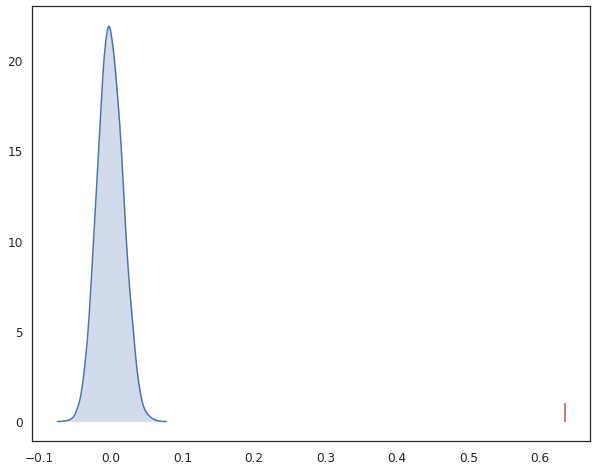

In [ ]:
mi.sim[0:5]
sns.kdeplot(mi.sim, shade=True) # Distribución simulada del Moran
plt.vlines(mi.I, 0, 1, color='r') # Moran Observado
plt.title('Distribución simulada del estadístico de Moran')

## Índices locales de Moran o LISA

Los indicadores locales de asociación espacial permiten tener una visión detallada del comportamiento de la dependencia espacial. Los LISA consisten básicamente en el cálculo del índice de Moran en versión local, es decir, se calcula un índice para cada unidad espacial, en el cual se compara el valor de la variable en la unidad espacial de referencia con respecto a las vecinas.

En particular, si el índice global de Moran permite establecer la existencia de dependencia espacial en la muestra, entonces los LISA permiten detectar agrupaciones de unidades espaciales que escapan al nivel de autocorrelación general. En este sentido, los LISA detectan atípicos espaciales, esto es, unidades espaciales que poseen un nivel de depencia espacial que supera la dependencia promedio, o en su defecto cuya dirección de dependencia es contraria a la tendencia general.

Los LISA se calculan con la función `Moran_Local` que recibe como argumentos la variable de interés y los pesos espaciales.

In [ ]:
# calculate Moran_Local and plot
#moran_loc_s = Moran_Local(shp.nbicab.fillna(100), wqs)
moran_loc_s = Moran_Local(shp.nbi2005, wqs)

Examine el contenido del objeto.

In [ ]:
# Examine los atributos del objeto
moran_loc_s.__dict__  # vars(moran_loc_s)

{'EI_sim': array([ 0.01286315, -0.00151217, -0.00541699, ..., -0.02036489,
        -0.00426787, -0.01421931]),
 'Is': array([ 1.95561491,  0.54473601, -0.1560949 , ...,  1.36133617,
         0.71772699,  2.40968585]),
 'VI_sim': array([0.20129292, 0.04340638, 0.10894767, ..., 1.09734228, 0.06315161,
        0.34305077]),
 'den': 1120.0,
 'geoda_quads': False,
 'n': 1120,
 'n_1': 1119,
 'p_sim': array([0.001, 0.002, 0.32 , ..., 0.103, 0.004, 0.001]),
 'p_z_sim': array([7.45035161e-06, 4.37227840e-03, 3.24015295e-01, ...,
        9.35854499e-02, 2.03270332e-03, 1.74839380e-05]),
 'permutations': 999,
 'q': array([3, 3, 2, ..., 1, 1, 1]),
 'quads': [1, 2, 3, 4],
 'rlisas': array([[ 4.29057021e-01, -2.89545556e-01, -1.46467523e-01, ...,
         -2.51794306e-01, -1.13402062e-01, -2.53206075e-01],
        [ 3.42851230e-01, -1.12240214e-01,  1.07484373e-01, ...,
         -5.61607241e-06,  1.75815143e-01, -4.62322716e-02],
        [ 5.06732956e-01, -1.05503796e-01,  1.77719524e-01, ...,
     

In [ ]:
dir(moran_loc_s)

['EI_sim',
 'Is',
 'VI_sim',
 '_Moran_Local__calc',
 '_Moran_Local__quads',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_statistic',
 'by_col',
 'den',
 'geoda_quads',
 'n',
 'n_1',
 'p_sim',
 'p_z_sim',
 'permutations',
 'q',
 'quads',
 'rlisas',
 'seI_sim',
 'sim',
 'w',
 'y',
 'z',
 'z_sim']

In [ ]:
moran_loc_s.q # Clusters

array([3, 3, 2, ..., 1, 1, 1])

In [ ]:
moran_loc_s.p_sim # P valores

array([0.001, 0.002, 0.32 , ..., 0.103, 0.004, 0.001])

### Diagrama de dispersión de Moran

El diagrama de dispersión de Moran es una representación visual que permite clasificar las unidades espaciales en cuatro cuadrantes o agrupamientos (ver Anselin, 1995). 

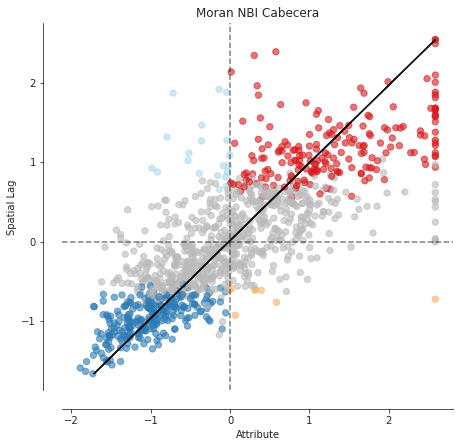

In [ ]:
with sns.axes_style("white"):
 moran_scatterplot(moran_loc_s, p=0.05)
 plt.title("Moran NBI Cabecera")
 #plt.savefig('ml_scatter.png')
 plt.show()

### Mapa de clusters LISA

El mapa de clusters LISA representa en un mapa coropleto las unidades espaciales para las cuales el índice local de Moran es estadísticamente significativo, y clasificadas según los agrupamientos definidos en el diagrama de dispersión de Moran. Para producir el mapa de clusters se recurre a la función `lisa_cluster`.

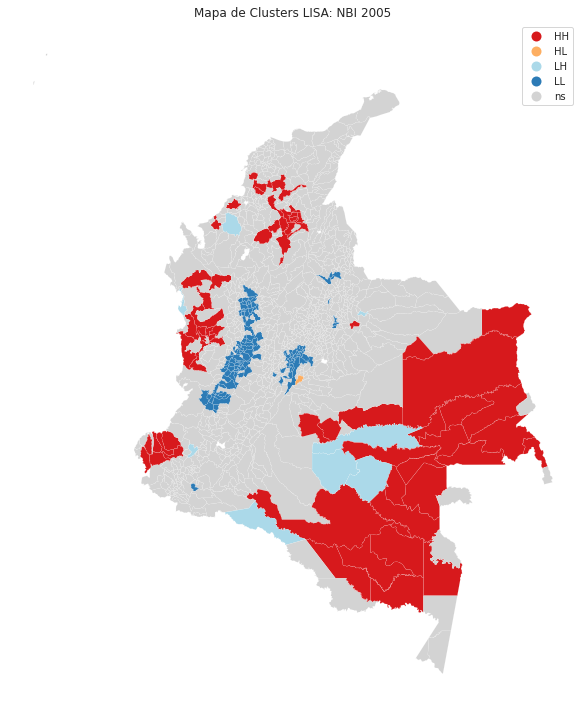

In [ ]:
with sns.axes_style("white"):
 lisa_cluster(moran_loc_s, shp, p=0.005, figsize=(10,10))
 plt.title('Mapa de Clusters LISA: NBI 2005')
 plt.tight_layout()
 #plt.savefig('lisa_clusters.png')
 plt.show()

# Referencias
https://pysal.org/esda/notebooks/spatialautocorrelation.html

https://splot.readthedocs.io/en/stable/users/tutorials/weights.html#subset